In [39]:
import pandas as pd
import math
import numpy as np
import os

import timeit as time
from random import sample
from statistics import mean

# import statsmodels.stats.api as sms
import matplotlib.pyplot as plt
import scipy

from scipy.stats import skew

In [29]:
#FUNCTION DEFINITIONS
def mean_confidence_interval(data, confidence=0.95):
    '''
    Function to get confidence interval of list of data
    '''
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h
def monthminus(i):
    '''
    get the previous month
    '''
    if(i == 192606):
        return i
    elif(i%100 == 1):
        year = i//100
        return (year-1)*100 + 12
    else:
        return i-1   
    
def checkEqual(lst):
   return lst[1:] == lst[:-1]

def monthdifference(dob, curr):
    ydob = dob//100
    ycur = curr//100
    mdob = dob%100
    mcur = curr%100
    return (ycur-ydob)*12 + mcur-mdob

def intersect(previndex, available):
    PERMNOlist_prev = list(data.iloc[previndex,0])
    PERMNO_cur = data.iloc[available,0]
    PERMNO_cur2 = list(PERMNO_cur.loc[PERMNO_cur.isin(PERMNOlist_prev)].index)
    print(PERMNO_cur2)
    return PERMNO_cur2

starty = 1926  
startm = 7
endy = 2016
N = 100
startd = starty*100 + startm  
    

In [30]:
#DATA LOADING
data = pd.read_csv('./newdata2.csv') #data only containing relevant share codes
fulldata = pd.read_csv('./fulldata2.csv') #data containing all share codes (to accomodate reclassification)

In [31]:
#DATA PREPROCESSING - limited sharecodes

fulldata = fulldata[~fulldata.SHRCD.isna()]

codereplace = [500,520,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,580,584]
retcodereplace = ['A','S','T','P']
data.loc[data['DLSTCD'].isin(codereplace) & data['DLRET'].isin(retcodereplace), 'DLRET' ] = -0.3
data.loc[data['DLRET'].isin(retcodereplace), 'DLRET'] = -.9999



data['RET'] = data['RET'].fillna(0.00)
data['RETX'] = data['RETX'].fillna(0.00)
data['DLRET'] = data['DLRET'].fillna(0.00)
data.loc[data['RET'].isin(['A','B','C','D','E']), 'RET'] = 0.00
data.loc[data['RETX'].isin(['A','B','C','D','E']), 'RETX'] = 0.00
# data = data.loc[~data['RET'].isin(['B','C'])]
data = data.drop_duplicates(subset=['PERMNO','date','RET'], keep = 'first')


data['date'] = data['date']//100  #only care about monthly returns
# data['date'] = pd.to_datetime(data['date'], format="%Y%m")
# data['date']
    
#ADDING IN DOB
dateofbirths = data.sort_values(by = 'date').drop_duplicates(subset = ['PERMNO'],keep='first')
dateofbirths = dateofbirths.rename(columns={'date':'dateofbirth'})
data = data.merge(dateofbirths[['PERMNO','dateofbirth']], on = 'PERMNO', how = 'left')

#adding in Date of Delisting    
delistings = data.loc[~data['DLSTCD'].isna()]
delistings=  delistings.rename(columns = {'date':'dateofdelisting'})
data = data.merge(delistings[['PERMNO','dateofdelisting']], on = 'PERMNO', how = 'left')


#delete rows  that are useless delisting returns
indexNames = list(data[data['PRC'].isna() & data['SHROUT'].isna() & (data['dateofdelisting']<data['date'])].index)
data.drop(indexNames, inplace = True)


#get Age by month
data['Age'] = (monthdifference(data['dateofbirth'],data['date'])+1)
#get Size
data['Size'] = data['SHROUT'] * abs(data['PRC'])

data['Size'].fillna(method='ffill', inplace=True)

data['RET'] = data['RET'].apply(pd.to_numeric)
data['RETX'] = data['RETX'].apply(pd.to_numeric)

data['DLRET'] = data['DLRET'].apply(pd.to_numeric)

ret_max1 = data[['date','RET','PERMNO']]

ret_max = ret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'RET')  #matrix of returns



In [32]:
#DATA PREPROCESSING - all sharecodes


listofPERMNO = data.PERMNO.unique()

#filter full data so that only PERMNOs that were at one time 10,11, or 12
fulldata = fulldata.loc[fulldata['PERMNO'].isin(listofPERMNO)]
fulldata['date'] = fulldata['date']//100


fulldata.loc[fulldata['DLSTCD'].isin(codereplace) & fulldata['DLRET'].isin(retcodereplace), 'DLRET' ] = -0.3
fulldata.loc[fulldata['DLRET'].isin(retcodereplace), 'DLRET'] = -.9999
# fulldata.loc[~fulldaDLSTCDta['DLRET'].isna(), 'DLRET'] = -.9999
fulldata['RET'] = fulldata['RET'].fillna(0.00)
fulldata['RETX'] = fulldata['RETX'].fillna(0.00)
fulldata['DLRET'] = fulldata['DLRET'].fillna(0.00)
fulldata.loc[fulldata['RET'].isin(['A','B','C','D','E']), 'RET'] = 0.00
fulldata.loc[fulldata['RETX'].isin(['A','B','C','D','E']), 'RETX'] = 0.00
# fulldata = fulldata.loc[~data['RET'].isin(['B','C'])]
fulldata = fulldata.drop_duplicates(subset=['PERMNO','date','RET'], keep = 'first')


#ADDING IN DOB
dateofbirths = fulldata.sort_values(by = 'date').drop_duplicates(subset = ['PERMNO'],keep='first')
dateofbirths = dateofbirths.rename(columns={'date':'dateofbirth'})
fulldata = fulldata.merge(dateofbirths[['PERMNO','dateofbirth']], on = 'PERMNO', how = 'left')

#adding in Date of Delisting    
delistings = fulldata.loc[~fulldata['DLSTCD'].isna()]
delistings=  delistings.rename(columns = {'date':'dateofdelisting'})
fulldata = fulldata.merge(delistings[['PERMNO','dateofdelisting']], on = 'PERMNO', how = 'left')

#delete useless delisting returns
print(fulldata.columns)
# print(fulldata['dateofdelisting'])
indexNames = list(fulldata[fulldata['PRC'].isna() & (fulldata['dateofdelisting']<fulldata['date'])].index)
fulldata.drop(indexNames, inplace = True)

#indexNames = list(fulldata[fulldata['PRC'].isna() & fulldata['dateofdelisting'].isna()].index)
indexNames = list(fulldata[fulldata['date']< 192606].index)

fulldata.drop(indexNames, inplace = True)


fulldata.loc[fulldata.dateofbirth < 192606, 'dateofbirth'] = 192606

fulldata['Age'] = (monthdifference(fulldata['dateofbirth'],fulldata['date'])+1)

fulldata['RET'] = fulldata['RET'].apply(pd.to_numeric)
fulldata['RETX'] = fulldata['RETX'].apply(pd.to_numeric)
fulldata['DLRET'] = fulldata['DLRET'].apply(pd.to_numeric)

ret_max1 = fulldata[['date','RET','PERMNO']]
ret_max2 = fulldata[['date','RETX','PERMNO']]
dlret_max1 = fulldata[['date','DLRET','PERMNO']]
age_max1 = fulldata[['date','Age','PERMNO']]
price_max1 = fulldata[['date', 'PRC','PERMNO']]
# div_max1 = fulldata[['date','DIVAMT','PERMNO']]
#size_max1 = fulldata[['date','Size','PERMNO']]

full_ret_max = ret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'RET')
nodiv_full_ret_max = ret_max2.pivot(index = 'PERMNO', columns = 'date', values = 'RETX')
dlret_max = dlret_max1.pivot(index = 'PERMNO', columns = 'date', values = 'DLRET')    
age_max =  age_max1.pivot(index = 'PERMNO', columns = 'date', values = 'Age')
price_max = price_max1.pivot(index = 'PERMNO', columns = 'date', values = 'PRC')
# div_max = div_max1.pivot(index='PERMNO',columns='date',values='DIVAMT')
#size_max = size_max1.pivot(index = 'PERMNO', columns = 'date', values = 'Size')

Index(['PERMNO', 'date', 'SHRCD', 'DLSTCD', 'RCRDDT', 'DLRET', 'PRC', 'RET',
       'SHROUT', 'RETX', 'dateofbirth', 'dateofdelisting'],
      dtype='object')


In [33]:
month = startm
year=  starty

listofdates = []
listofavailable = {}
listofavailable2 = {}
listofyears = []
fulllistofavailable = {}
while(year<=endy):
    listofyears.append(year)
    while(month <= 12):
        curdate = year*100 + month
        listofdates.append(curdate)
        y = ret_max.index[(ret_max[curdate].notnull())].tolist()
        x = full_ret_max.index[(full_ret_max[curdate].notnull())].tolist()
        listofavailable[curdate] = y
        fulllistofavailable[curdate] = x
        month += 1
    month = 1
    year += 1

In [42]:
#Rebalanced Simulation
ew_ret = {} #dictionary of monthly returns   
start = timeit.default_timer()
exits = []
entrants = []
simulation_num = 1000
ret_list = []
# in_list = []
numof = []
agedict = {}
ew_ret_list = {}
year = starty
month = startm

turnover_list = []

while(year <= endy):
    while(month<= 12):
        curdate=  year*100 + month
        agedict[curdate] = []
        month+=1
    month = 1
    year += 1
    
    
n_list = [5,25,50,100]
ret_dict = {}
turnover_dict = {}
turnover_dict_list = {}
ret_dict_list = {}
age_dict_list = {}
for w in n_list:
    ret_dict[w] = []
    turnover_dict[w] = {}
    ret_dict_list[w] = {}
    age_dict_list[w] = {}
    turnover_dict_list[w] = {}
    for i in listofdates:
        turnover_dict_list[w][i] = []
        ret_dict_list[w][i] = []
        age_dict_list[w][i] = []
    
# ret_dict = {5:[],25:[],50:[],100:[]}
# turnover_dict = {5:[],25:[],50:[],100:[]}


start = time.timeit()
for N in n_list:
    for j in range(0,simulation_num):
        if j % 100==0:
            end = time.timeit()
            print(f'time taken: {end-start}')
            print(j)
            start = time.timeit()
        ew_ret = {}
        turnover = []
        turnover_2 = []
        exits = []
        entrants = []
        in_list = []
        numof = []
        prev_sample = []
        total_ret = 1
        for i in listofdates:
            if(i == startd):
                prev_sample = sample(listofavailable[i],N)
                prev_prices = price_max.loc[prev_sample,i] #get prices
                ew_ret[i] = sum(ret_max.loc[prev_sample,i])
                ew_ret[i] += sum(dlret_max.loc[prev_sample,i])
                ew_ret[i] = 1 + ew_ret[i] /N
                ret_dict_list[N][i].append(ew_ret[i])
                #in_list.append((i,prev_sample,j, len(prev_sample), mean(age_max.loc[prev_sample,i]), mean(size_max.loc[prev_sample,i])))
                averageage = mean(age_max.loc[prev_sample,i])
                age_dict_list[N][i].append(averageage)
                turn = np.mean(np.abs(ret_max.loc[prev_sample,i].values))
                turnover_dict_list[N][i].append(turn)
                turnover.append(turn)
            else:
                cur_sample = list(set(prev_sample)& set(listofavailable[i])) #find items in next date
                #in_list.append((i,cur_sample, j, len(cur_sample), mean(age_max.loc[cur_sample,i]), mean(size_max.loc[cur_sample,i])))


                diff = list(set(prev_sample) - set(cur_sample)) #find items that have exited either due to reclassification or delisting
                reclassified = list(set(fulllistofavailable[i]) & set(diff)) #find items that have been reclassified

                cur_sample = cur_sample + reclassified #add back in items that have been reclassified
                
                percent_prc_chg = np.abs(nodiv_full_ret_max.loc[cur_sample,i])

                exitnum = N - len(cur_sample) #how many stocks have exited
                turn = (np.mean(percent_prc_chg) * len(cur_sample) + exitnum)/N
                turnover_dict_list[N][i].append(turn)
                turnover.append(turn)

                filling = sample(set(listofavailable[i])-set(cur_sample), exitnum) #sample in to fill exited stocks

                if(len(filling)>0):  #add new samples to portfolio
                    cur_sample.extend(filling) 
                    
                normal_returns = full_ret_max.loc[cur_sample,i]
                delisting_returns = dlret_max.loc[cur_sample,i]


                ew_ret[i] = sum(normal_returns) #get return matrix
                ew_ret[i] += sum(delisting_returns) #get delisting returns
                ew_ret[i] = 1 + ew_ret[i]/N #return for a given month
                
                ret_dict_list[N][i].append(ew_ret[i]) #append to monthly return list
                
                averageage = mean(age_max.loc[prev_sample,i])
                age_dict_list[N][i].append(averageage)
                
                prev_sample = cur_sample
            total_ret = total_ret * ew_ret[i] #keep a running track of total return

        annualizedret = total_ret ** (1/((len(listofdates)-1)/12)) -1
        ret_dict[N].append(annualizedret)
        total_turnover = sum(turnover)/len(turnover)
#         total_turnover_2 = sum(turnover_2)/len(turnover_2)
        turnover_dict[N].append(total_turnover)
#         print(total_turnover)
#         print(total_turnover_2)
#         print(annualizedret)
    #     num = np.prod(ew_ret)
    print(turnover_dict)
    print(ret_dict)

time taken: -0.004175378940999508
0
time taken: -0.005497956182807684
100
time taken: -5.781184881925583e-06
200
time taken: -7.047085091471672e-05
300
time taken: -0.0008991130162030458
400
time taken: 4.0790997445583344e-05
500
time taken: 0.0007629380561411381
600
time taken: 4.860805347561836e-05
700
time taken: -8.387723937630653e-06
800
time taken: 7.520988583564758e-05
900
{5: [0.09911742983425419, 0.08091830847145495, 0.0932928215469615, 0.09446679042357276, 0.0865200911602211, 0.07509403830570902, 0.09305482099447508, 0.09730766813996317, 0.08272365451197052, 0.07892610828729284, 0.08865450386740342, 0.07461097274401483, 0.09031233738489865, 0.09809184364640888, 0.08292772191528548, 0.0841634114180477, 0.0932212815837938, 0.07353482651933697, 0.08180732744014722, 0.07784239926335182, 0.07938439779005525, 0.08358733775322282, 0.10321793591160221, 0.07684349742173104, 0.07925602983425423, 0.09814305598526696, 0.09258974769797437, 0.09152646298342541, 0.09851473462246768, 0.10242

time taken: 1.8252059817314148e-05
100
time taken: 1.5046913176774979e-05
200
time taken: -9.399699047207832e-05
300
time taken: 0.0009402572177350521
400
time taken: 0.0002530182246118784
500
time taken: -8.772616274654865e-05
600
time taken: 8.181203156709671e-06
700
time taken: 5.2422983571887016e-05
800
time taken: 1.6703037545084953e-05
900
{5: [0.09911742983425419, 0.08091830847145495, 0.0932928215469615, 0.09446679042357276, 0.0865200911602211, 0.07509403830570902, 0.09305482099447508, 0.09730766813996317, 0.08272365451197052, 0.07892610828729284, 0.08865450386740342, 0.07461097274401483, 0.09031233738489865, 0.09809184364640888, 0.08292772191528548, 0.0841634114180477, 0.0932212815837938, 0.07353482651933697, 0.08180732744014722, 0.07784239926335182, 0.07938439779005525, 0.08358733775322282, 0.10321793591160221, 0.07684349742173104, 0.07925602983425423, 0.09814305598526696, 0.09258974769797437, 0.09152646298342541, 0.09851473462246768, 0.10242030073664835, 0.08775656740331488, 

time taken: -6.294227205216885e-05
100
time taken: 1.1255033314228058e-05
200
time taken: -5.696411244571209e-05
300
time taken: -0.00013322895392775536
400
time taken: -4.4730957597494125e-05
500
time taken: -2.6238150894641876e-05
600
time taken: 3.3895717933773994e-05
700
time taken: -7.450813427567482e-05
800
time taken: 3.874907270073891e-05
900
{5: [0.09911742983425419, 0.08091830847145495, 0.0932928215469615, 0.09446679042357276, 0.0865200911602211, 0.07509403830570902, 0.09305482099447508, 0.09730766813996317, 0.08272365451197052, 0.07892610828729284, 0.08865450386740342, 0.07461097274401483, 0.09031233738489865, 0.09809184364640888, 0.08292772191528548, 0.0841634114180477, 0.0932212815837938, 0.07353482651933697, 0.08180732744014722, 0.07784239926335182, 0.07938439779005525, 0.08358733775322282, 0.10321793591160221, 0.07684349742173104, 0.07925602983425423, 0.09814305598526696, 0.09258974769797437, 0.09152646298342541, 0.09851473462246768, 0.10242030073664835, 0.08775656740331

time taken: 7.142219692468643e-05
100
time taken: -0.0008662273176014423
200
time taken: -1.3526063412427902e-05
300
time taken: -2.28129792958498e-05
400
time taken: -9.475112892687321e-05
500
time taken: 2.8881942853331566e-05
600
time taken: -4.6318164095282555e-05
700
time taken: 1.8585240468382835e-05
800
time taken: 1.813611015677452e-05
900
{5: [0.09911742983425419, 0.08091830847145495, 0.0932928215469615, 0.09446679042357276, 0.0865200911602211, 0.07509403830570902, 0.09305482099447508, 0.09730766813996317, 0.08272365451197052, 0.07892610828729284, 0.08865450386740342, 0.07461097274401483, 0.09031233738489865, 0.09809184364640888, 0.08292772191528548, 0.0841634114180477, 0.0932212815837938, 0.07353482651933697, 0.08180732744014722, 0.07784239926335182, 0.07938439779005525, 0.08358733775322282, 0.10321793591160221, 0.07684349742173104, 0.07925602983425423, 0.09814305598526696, 0.09258974769797437, 0.09152646298342541, 0.09851473462246768, 0.10242030073664835, 0.08775656740331488

In [ ]:
#Bootstrapped Simulation

simulation_num = 100

boot_ret_list = []

for j in range(0,simulation_num):
    print(j)
    for i in listofdates:
        prev_sample = sample(listofavailable[i],N)
        ew_ret[i] = sum(ret_max.loc[prev_sample,i])
        ew_ret[i] += sum(dlret_max.loc[prev_sample,i])
        ew_ret[i] = 1 + ew_ret[i] /N
        averageage = mean(age_max.loc[prev_sample,i])
        agedict[i].append(averageage)
    total_ret = 1.00
    for key in ew_ret:
        total_ret = total_ret * ew_ret[key]
                        
    annualizedret = total_ret ** (1/(len(listofdates)/12)) -1
    boot_ret_list.append(annualizedret)
    print(annualizedret)
            



Rebalanced Portfolio
Portfolio Size: 5 - Mean Return:0.11138844899962719, Median Return: 0.11136829999939057 Skew Return:-0.1359394666473667,Mean Turnover: 0.08683253244069981,Skew Turnover: 0.04092991401620047
Portfolio Size: 25 - Mean Return:0.12601035893097384, Median Return: 0.12592002574429095 Skew Return:0.013690645592699691,Mean Turnover: 0.08661898831093923,Skew Turnover: 0.06440368990390351
Portfolio Size: 50 - Mean Return:0.12796225880852918, Median Return: 0.12827309542998255 Skew Return:-0.15301724912018166,Mean Turnover: 0.08665329100209945,Skew Turnover: -0.1140610928825148
Portfolio Size: 100 - Mean Return:0.12889872946485106, Median Return: 0.12881774407816204 Skew Return:0.060521167771041225,Mean Turnover: 0.0868007756998895,Skew Turnover: -0.003153487907712447
[datetime.date(1926, 7, 1), datetime.date(1926, 8, 1), datetime.date(1926, 9, 1), datetime.date(1926, 10, 1), datetime.date(1926, 11, 1), datetime.date(1926, 12, 1), datetime.date(1927, 1, 1), datetime.date(1927

0.07911153231479999


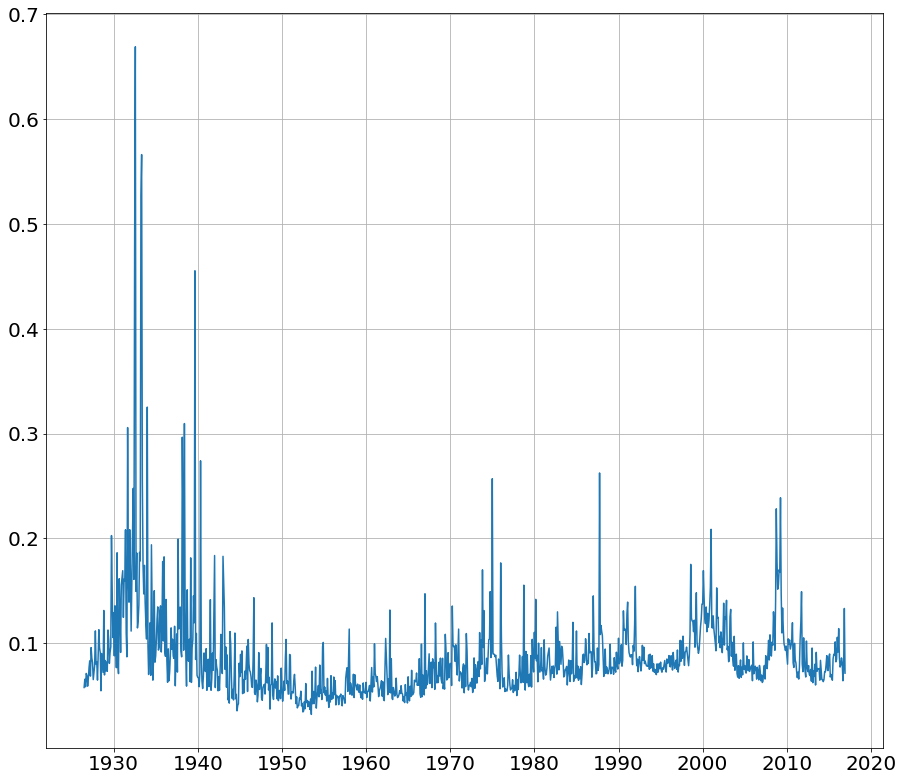

In [98]:
import json
from datetime import datetime
import matplotlib.dates as mdates
from statistics import median
# dict = {'Python' : '.py', 'C++' : '.cpp', 'Java' : '.java'}



print('Rebalanced Portfolio')
# print(turnover_dict[100].index(2.3125063105893187))
for size in n_list:
    rounded_avg_turnover = [ round(elem, 2) for elem in ret_dict[size]]
    print(f'Portfolio Size: {size} - Mean Return:{mean(ret_dict[size])}, Median Return: {median(ret_dict[size])} Skew Return:{skew(ret_dict[size])},Mean Turnover: {mean(turnover_dict[size])},Skew Turnover: {skew(turnover_dict[size])}')
# print(f'Bootstrapped Returns- Mean:{mean(boot_ret_list)},Skew:{skew(boot_ret_list)}')
avg_dict_ret = {}
avg_dict_turn = {}
for i in listofdates:
    avg_dict_ret[i] = sum(ret_dict_list[100][i])/len(ret_dict_list[100][i])
    avg_dict_turn[i] = sum(turnover_dict_list[100][i])/len(turnover_dict_list[100][i])

    

dates = list(avg_dict_turn.keys())           # list() needed for python 3.x
for l in range(0,len(dates)):
    date = datetime.strptime(str(dates[l]), '%Y%m').date()
    dates[l] = date
AVG_turnover = list(avg_dict_turn.values())        # ditto
rounded_avg_turnover = [ round(elem, 2) for elem in AVG_turnover]
fig, ax = plt.subplots()

#set locator to every decade
locator = mdates.YearLocator(10)

ax.xaxis.set_major_locator(locator)



ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()


ax.plot_date(dates, AVG_turnover, '-')


fig.set_figheight(15)
fig.set_figwidth(15)

# fig.suptitle('Turnover Through Time', fontsize=20)
ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

fig.suptitle('Rebalanced Portfolio Overtime')

fig.savefig('turnover.png')





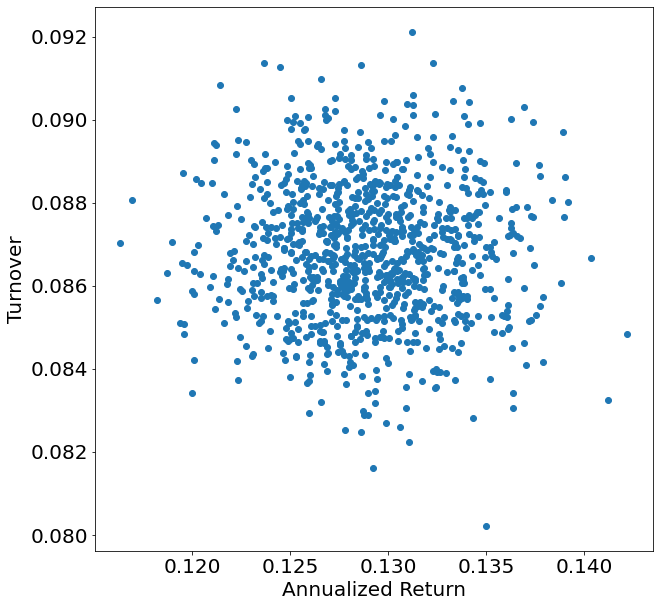

In [106]:
from sklearn.linear_model import LinearRegression

x = np.asarray(ret_dict[100])
y = np.asarray(turnover_dict[100])
fig, ax = plt.subplots()
ax.scatter(x,y)

ax.set_xlabel('Annualized Return', fontsize = 20)
ax.set_ylabel('Turnover', fontsize = 20)
fig.set_figheight(10)
fig.set_figwidth(10)

ax.tick_params(axis="x", labelsize=20)
ax.tick_params(axis="y", labelsize=20)

fig.savefig('scatter.png')

# model = LinearRegression().fit(x, y)
